In [1]:
import seaborn as sns
import matplotlib 

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.stats import skew, kurtosis

import math
from sys import path
path.append('..//modules')
path.append('..//dumps//reg_dmo_pdf')
import time
import pandas as pd
import psycopg2 as pg
from geoalchemy2 import Geometry, WKTElement
from sqlalchemy import create_engine, MetaData, Table
import pandas.io.sql as psql

#create a postgres engine and a pg connection
from modules.db_connector import *
print("DB connecting engine imported")


#print(matplotlib.rcParams.keys())

font = {'family' : 'Roboto', 
        'weight': '300',
        'size'   : 20}


axesfoo = {'labelweight': '300'}
#unified_colors
clr_mean = "red"
clr_mode = "black"
clr_median = "orange"

import matplotlib 
matplotlib.rc('font', **font)
matplotlib.rc('axes', **axesfoo)

#https://medium.com/dunder-data/automatically-wrap-graph-labels-in-matplotlib-and-seaborn-a48740bc9ce
import textwrap
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)
    

DB connecting engine imported


In [2]:
with engine.connect() as con1:
    q = """
select *,  
    CASE 
        WHEN poi_n_reviews is null THEN 'Not rated'
        WHEN poi_n_reviews is not null THEN 'Rated'
        ELSE null
    END recorded_review
    from gtlab.sk_pois_activities_tripadvisor_0723_details
left join (select dmo_id, 'DMO ' || dmo_id nm_dmoid, dmo_name, dmo_cin from  gtlab.sk_dmos_raw) dms using (dmo_id)
left join (select "Kód_obce" gku_municipality_id, "Názov_obce" muncipality_name, "Výmera_z_registra" municipal_sqm from gtlab.sk_municipalities_gku) muns using (gku_municipality_id)
""" 	
    q2 = """
    with merged as (
with muns as (select "Kód_obce", "Výmera_z_registra" sqm from gtlab.sk_municipalities_gku),
dmos as (select dmo_id, "Kód_obce" from gtlab.sk_dmo_boundaries_susr_codes) 
select * from muns left join dmos using ("Kód_obce")
)
select case when dmo_id is null then 'NO DMO' else 'DMO ' || dmo_id end nm_dmoid, round(sum(sqm::numeric)/1000000::numeric, 3) sqkm
from merged group by nm_dmoid
order by sqkm desc
    """
    q3 = """
    with foo as  (
	select 
sk_ta_trp_cat_test.trp_1_source, sk_ta_trp_cat_test.trp_2_class, sk_ta_trp_cat_test.trp_3_subclass,
sk_pois_activities_tripadvisor_0723_details.poi_n_reviews, sk_pois_activities_tripadvisor_0723_details.poi_rating
from gtlab.sk_ta_trp_cat_test, gtlab.sk_pois_activities_tripadvisor_0723_details
where sk_ta_trp_cat_test.id = sk_pois_activities_tripadvisor_0723_details.id
)
select
trp_1_source, trp_2_class, trp_3_subclass, 
count(*), sum(poi_n_reviews) n_reviews_total, round(avg(poi_rating)::numeric,2) avg_rating_per_group
from foo
group by trp_1_source, trp_2_class, trp_3_subclass
"""
    q4 = """
    select sk_pois_activities_tripadvisor_0723_details.id, sk_pois_activities_tripadvisor_0723_details.dmo_id, 
    'DMO ' || sk_pois_activities_tripadvisor_0723_details.dmo_id nm_dmoid,
sk_ta_trp_cat_test.trp_1_source, sk_ta_trp_cat_test.trp_2_class, sk_ta_trp_cat_test.trp_3_subclass, sk_ta_trp_cat_test.trp_4_groups,
sk_pois_activities_tripadvisor_0723_details.poi_n_reviews, sk_pois_activities_tripadvisor_0723_details.poi_rating
from gtlab.sk_ta_trp_cat_test, gtlab.sk_pois_activities_tripadvisor_0723_details
where sk_ta_trp_cat_test.id = sk_pois_activities_tripadvisor_0723_details.id
and sk_pois_activities_tripadvisor_0723_details.dmo_id is not null
"""
    q5 = """
    select 'DMO ' || dmo_id nm_dmoid,  dmo_id, sum(value) vis_sum_months
from  gtlab.sk_dest_visitors_23_susr
where cr3803mr_mes <> '1. - 12.' 
group by dmo_id
"""
    q6 = """
    select *, case when dmo_id is null then 'NO DMO' else 'DMO ' || dmo_id end nm_dmoid from gtlab.sk_pois_activities_tripadvisor_0723_details
left join (select * from gtlab.sk_ta_trp_cat_test) trp using (id)
left join (select id tr_subgroup_5, name trp_5_subgroups  from gtlab.trp_5_subgroups) trp5 using(tr_subgroup_5)

 """
    df_ta_poi = pd.read_sql(q, con=con1)
    df_ta_poi_all = pd.read_sql(q, con=con1)
    df_dmo_sqkm = pd.read_sql(q2, con=con1)
    df_ta_poi_trp = pd.read_sql(q3, con=con1)
    df_ta_poi_trp_in_dmo = pd.read_sql(q4, con=con1)
    df_susr_dist_vis23 = pd.read_sql(q5, con=con1)
    df_trp_all = pd.read_sql(q6, con=con1)
    con1.close()


    
df_ta_poi["in_dmo"] = [str(x).replace(str(x), "Within DMO boundaries", 1) if str(x) != 'nan' else str(x).replace(str(x), "Not within DMO boundaries", 1) for x in df_ta_poi["dmo_id"] ]
df_ta_poi['nm_dmoid'] = df_ta_poi['nm_dmoid'].fillna(value='NO DMO')
df_ta_poi_group_dmo = df_ta_poi.groupby("nm_dmoid", dropna=True).count()
df_ta_poi_sorted = df_ta_poi.copy()

df_ta_poi_group_dmo['dmo'] = df_ta_poi_group_dmo.index
df_ta_poi_group_dmo_all = df_ta_poi_group_dmo.copy()
df_ta_poi_group_dmo = df_ta_poi_group_dmo.query('dmo != "NO DMO"')
df_ta_poi_all = df_ta_poi_sorted.copy()
df_ta_poi_sorted = df_ta_poi_sorted.query('nm_dmoid != "NO DMO"')
df_ta_poi_sorted['nm_dmoid'] = pd.Categorical(df_ta_poi_sorted['nm_dmoid'], list(df_ta_poi_group_dmo.sort_values(by=['id'], ascending=False).index))



df_ta_poi_sorted['nm_dmoid'] = pd.Categorical(df_ta_poi_sorted['nm_dmoid'], list(df_ta_poi_group_dmo.sort_values(by=['id'], ascending=False).index))


df_poi_per_dmo = pd.pivot_table(df_ta_poi_sorted, index = 'nm_dmoid', columns=['recorded_review'], values = 'id', aggfunc='count')

df_poi_per_sqkm_dmo = pd.merge(df_poi_per_dmo, df_dmo_sqkm, left_on=df_poi_per_dmo.index, right_on=df_dmo_sqkm.nm_dmoid, how='left')
df_poi_per_sqkm_dmo['rated_per_sqkm'] = round(df_poi_per_sqkm_dmo['Rated'] / df_poi_per_sqkm_dmo.sqkm, 2)
df_poi_per_sqkm_dmo['not_rated_per_sqkm'] = round(df_poi_per_sqkm_dmo['Not rated'] / df_poi_per_sqkm_dmo.sqkm, 2)
df_poi_per_sqkm_dmo['poi_per_sqkm'] = round((df_poi_per_sqkm_dmo['Not rated'] + df_poi_per_sqkm_dmo['Rated']) / df_poi_per_sqkm_dmo.sqkm, 2)
df_poi_per_sqkm_dmo_rated = df_poi_per_sqkm_dmo[['nm_dmoid', 'rated_per_sqkm']]
df_poi_per_sqkm_dmo_rated['Value'] = df_poi_per_sqkm_dmo.rated_per_sqkm
df_poi_per_sqkm_dmo_rated['cat'] = 'Rated'
df_poi_per_sqkm_dmo_rated.drop(columns=['rated_per_sqkm'])
df_poi_per_sqkm_dmo_not_rated = df_poi_per_sqkm_dmo[['nm_dmoid', 'not_rated_per_sqkm']]
df_poi_per_sqkm_dmo_not_rated['Value'] = df_poi_per_sqkm_dmo_not_rated.not_rated_per_sqkm
df_poi_per_sqkm_dmo_not_rated['cat'] = 'Not rated'
df_poi_per_sqkm_dmo_not_rated.drop(columns=['not_rated_per_sqkm'])
df_poi_per_sqkm_rated_not_rated =pd.concat([df_poi_per_sqkm_dmo_rated, df_poi_per_sqkm_dmo_not_rated])
df_poi_per_sqkm_rated_not_rated['nm_dmoid'] = pd.Categorical(df_poi_per_sqkm_rated_not_rated['nm_dmoid'], list(pd.pivot_table(df_poi_per_sqkm_rated_not_rated, index='nm_dmoid', values = "Value", aggfunc = 'sum').sort_values(by=["Value"], ascending=False).index))

#df_poi_per_sqkm_dmo['poi_per_sqkm'] = pd.Categorical(df_poi_per_sqkm_dmo['nm_dmoid'], list(df_poi_per_sqkm_dmo.sort_values(by=['poi_per_sqkm'], ascending=False).index))
#df_poi_per_sqkm_dmo = df_poi_per_sqkm_dmo.sort_values(by=['poi_per_sqkm'], ascending=False)

C:\Users\csb\AppData\Local\Temp\ipykernel_748\1516251883.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_poi_per_sqkm_dmo_rated['Value'] = df_poi_per_sqkm_dmo.rated_per_sqkm
C:\Users\csb\AppData\Local\Temp\ipykernel_748\1516251883.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_poi_per_sqkm_dmo_rated['cat'] = 'Rated'
C:\Users\csb\AppData\Local\Temp\ipykernel_748\1516251883.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [3]:

df_dmo_manu_desc = pd.pivot_table(df_ta_poi_sorted, index = 'in_dmo', values = 'id', aggfunc='count')
df_dmo_manu_desc['share'] = df_dmo_manu_desc['id'] / df_dmo_manu_desc['id'].sum() *100
n_dmos_with_ta_poi = len(df_ta_poi_sorted.dmo_id.unique()[1::])
df_pivot_poi_per_dmo = pd.pivot_table(df_ta_poi_sorted, index = 'nm_dmoid', values = 'id', aggfunc='count').query('nm_dmoid != "NO DMO"')
mean_n_poi_per_dmo = df_pivot_poi_per_dmo.id.mean()
df_ta_poi_sorted.nm_dmoid.unique()

df_poi_per_dmo['n'] = df_poi_per_dmo['Not rated'] + df_poi_per_dmo['Rated']
df_poi_per_dmo['% Not rated']= round(100*df_poi_per_dmo['Not rated'] / df_poi_per_dmo['n'],2)
df_poi_per_dmo['% Rated']= round(100*df_poi_per_dmo['Rated'] / df_poi_per_dmo['n'],2)
df_poi_per_dmo['Share on total POI'] = round(100*df_poi_per_dmo['n'] / df_poi_per_dmo['n'].sum())
df_poi_per_dmo['Share on all rated'] = round(100*df_poi_per_dmo['Rated'] / df_poi_per_dmo['Rated'].sum())
#df_poi_per_dmo.sort_values(by='Share on total POI', ascending=False)

df_ta_poi_sorted.query('dmo_id == 13')['dmo_name'].unique()



array(['Nitrianska OCR '], dtype=object)

C:\Users\csb\AppData\Local\Temp\ipykernel_19728\4091941075.py:25: UserWarning: The palette list has more values (12) than needed (2), which may not be intended.
  g1 = sns.histplot(data=df_ta_poi_sorted, x = "nm_dmoid", stat="count", multiple="stack",  palette = sns.color_palette("Paired")
C:\Users\csb\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\csb\AppData\Local\Temp\ipykernel_19728\4091941075.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(g1.get_xticklabels(), rotation=90)
C:\Users\csb\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

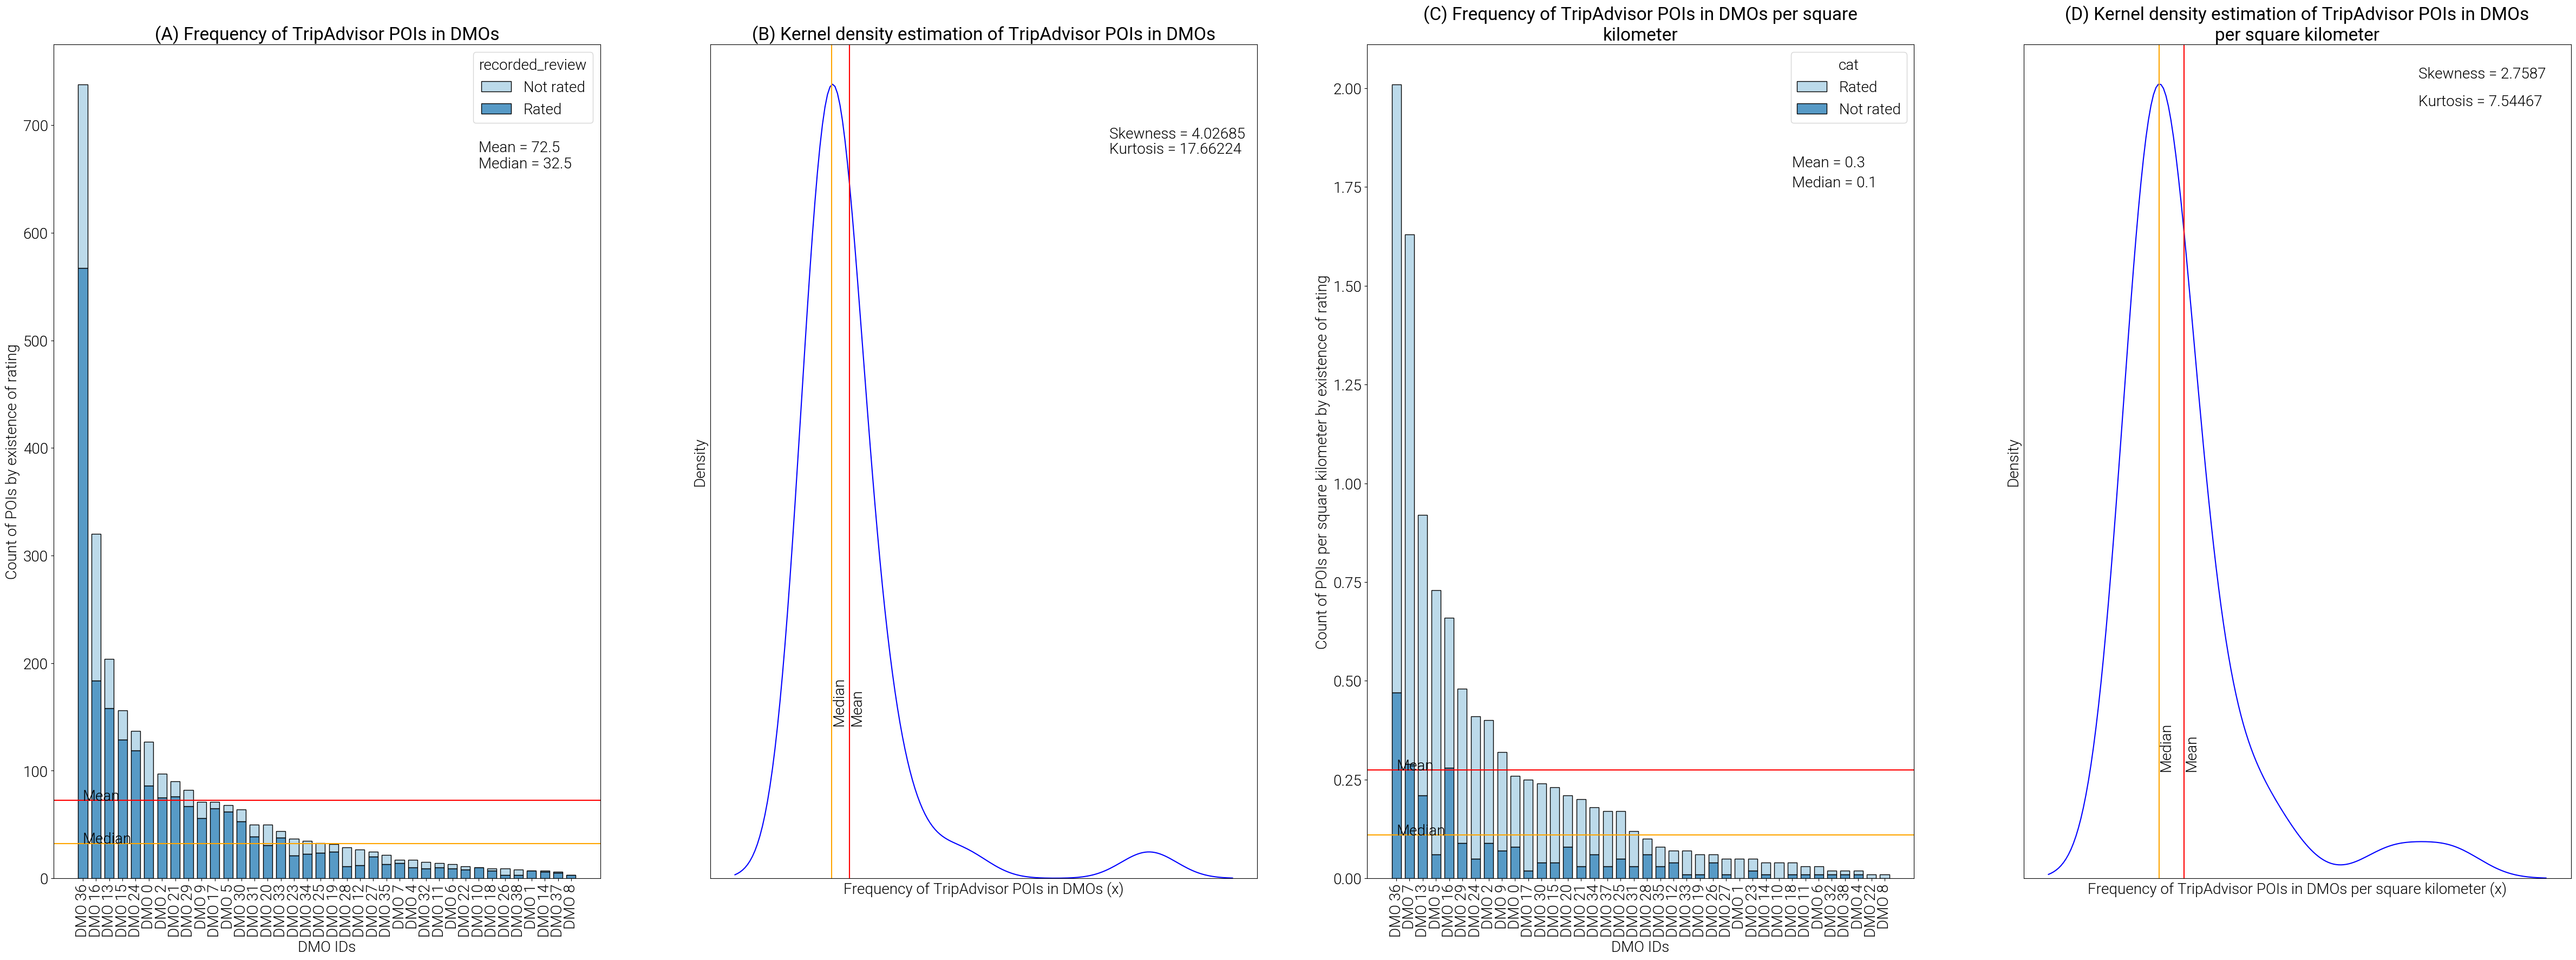

In [4]:
#POI in DMO







mean_poi_per_dmo = df_ta_poi_group_dmo.id.mean()
median_poi_per_dmo = df_ta_poi_group_dmo.id.median()
mode_poi_per_dmo = df_ta_poi_group_dmo.id.mode()
skew_poi_per_dmo = skew(df_ta_poi_group_dmo.id)
kurt_poi_per_dmo = kurtosis(df_ta_poi_group_dmo.id)

fig = plt.figure(figsize=(60, 20))
gs = GridSpec(1, 4, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[0, 3])


g1 = sns.histplot(data=df_ta_poi_sorted, x = "nm_dmoid", stat="count", multiple="stack",  palette = sns.color_palette("Paired")
 ,kde=False,shrink = 0.7, hue="recorded_review" , ax=ax1)
ax1.set_xticklabels(g1.get_xticklabels(), rotation=90)
ax1.set(xlabel="\n".join(textwrap.wrap('DMO IDs',60)), ylabel='Count of POIs by existence of rating')
ax1.set(title="\n".join(textwrap.wrap("(A) Frequency of TripAdvisor POIs in DMOs",60)))
ax1.axhline(mean_poi_per_dmo, color=clr_mean, label="Mean")
ax1.axhline(median_poi_per_dmo, color=clr_median, label="Median")
#ax1.axhline(mode_poi_per_dmo, color=clr_mode, label="Mode")
ax1.annotate("Mean", xy=(0,mean_poi_per_dmo))
ax1.annotate("Median", xy=(0,median_poi_per_dmo))
ax1.annotate("Mean = " + str(round(mean_poi_per_dmo,1)), xy=(30,675))
ax1.annotate("Median = " + str(round(median_poi_per_dmo,1)), xy=(30,660))


g2 =sns.kdeplot(df_ta_poi_group_dmo.id, color="blue", ax=ax2)
ax2.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
ax2.set(xlabel='Frequency of TripAdvisor POIs in DMOs (x)', ylabel='Density')
ax2.set(title="(B) Kernel density estimation of TripAdvisor POIs in DMOs")
ax2.axvline(mean_poi_per_dmo, color=clr_mean, label="Mean")
ax2.axvline(median_poi_per_dmo, color=clr_median, label="Median")
ax2.annotate("Mean", xy=(mean_poi_per_dmo,0.001),rotation=90)
ax2.annotate("Median", xy=(median_poi_per_dmo,0.001),rotation=90)
ax2.annotate("Skewness = " + str(round(skew_poi_per_dmo,5)), xy=(650,0.00475))
ax2.annotate("Kurtosis = " + str(round(kurt_poi_per_dmo,5)), xy=(650,0.00465))


mean_poi_per_dmo_sqkm = df_poi_per_sqkm_dmo.poi_per_sqkm.mean()
median_poi_per_dmo_sqkm = df_poi_per_sqkm_dmo.poi_per_sqkm.median()
mode_poi_per_dmo_sqkm = df_poi_per_sqkm_dmo.poi_per_sqkm.mode()
skew_poi_per_dmo_sqkm = skew(df_poi_per_sqkm_dmo.poi_per_sqkm)
kurt_poi_per_dmo_sqkm = kurtosis(df_poi_per_sqkm_dmo.poi_per_sqkm)



g3 = sns.histplot(data=df_poi_per_sqkm_rated_not_rated, x = "nm_dmoid", multiple="stack", weights ="Value", hue="cat",  palette = sns.color_palette("Paired"), 
                  ax=ax3, shrink=0.7)


ax3.set_xticklabels(g3.get_xticklabels(), rotation=90)
ax3.set(xlabel="\n".join(textwrap.wrap('DMO IDs',60)), ylabel='Count of POIs per square kilometer by existence of rating')
ax3.set(title="\n".join(textwrap.wrap("(C) Frequency of TripAdvisor POIs in DMOs per square kilometer",60)))
ax3.axhline(mean_poi_per_dmo_sqkm, color=clr_mean, label="Mean")
ax3.axhline(median_poi_per_dmo_sqkm, color=clr_median, label="Median")
ax3.annotate("Mean", xy=(0,mean_poi_per_dmo_sqkm))
ax3.annotate("Median", xy=(0,median_poi_per_dmo_sqkm))
ax3.annotate("Mean = " + str(round(mean_poi_per_dmo_sqkm,1)), xy=(30,1.8))
ax3.annotate("Median = " + str(round(median_poi_per_dmo_sqkm,1)), xy=(30,1.75))

g4 =sns.kdeplot(df_poi_per_sqkm_dmo.poi_per_sqkm, color="blue", ax=ax4)
ax4.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
ax4.set(xlabel='Frequency of TripAdvisor POIs in DMOs per square kilometer (x)', ylabel='Density')
ax4.set(title="\n".join(textwrap.wrap("(D) Kernel density estimation of TripAdvisor POIs in DMOs per square kilometer",60)))
ax4.axvline(mean_poi_per_dmo_sqkm, color=clr_mean, label="Mean")
ax4.axvline(median_poi_per_dmo_sqkm, color=clr_median, label="Median")
ax4.annotate("Mean", xy=(mean_poi_per_dmo_sqkm,0.2),rotation=90)
ax4.annotate("Median", xy=(median_poi_per_dmo_sqkm,0.2),rotation=90)
ax4.annotate("Skewness = " + str(round(skew_poi_per_dmo_sqkm,5)), xy=(1.8, 1.45))
ax4.annotate("Kurtosis = " + str(round(kurt_poi_per_dmo_sqkm,5)), xy=(1.8,1.4))

plt.savefig("dumps/exported_figs/grid_dmo_base.svg", bbox_inches="tight")


C:\Users\csb\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\csb\AppData\Local\Temp\ipykernel_19728\3857963763.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(g1.get_xticklabels(), rotation=90)
C:\Users\csb\AppData\Local\Temp\ipykernel_19728\3857963763.py:53: UserWarning: The palette list has more values (12) than needed (3), which may not be intended.
  g2 = sns.histplot(data=dfg2, x = "nm_dmoid", multiple="stack", weights ="id", hue="type_of_rating",  palette = sns.color_palette("Paired"),
C:\Users\csb\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN 

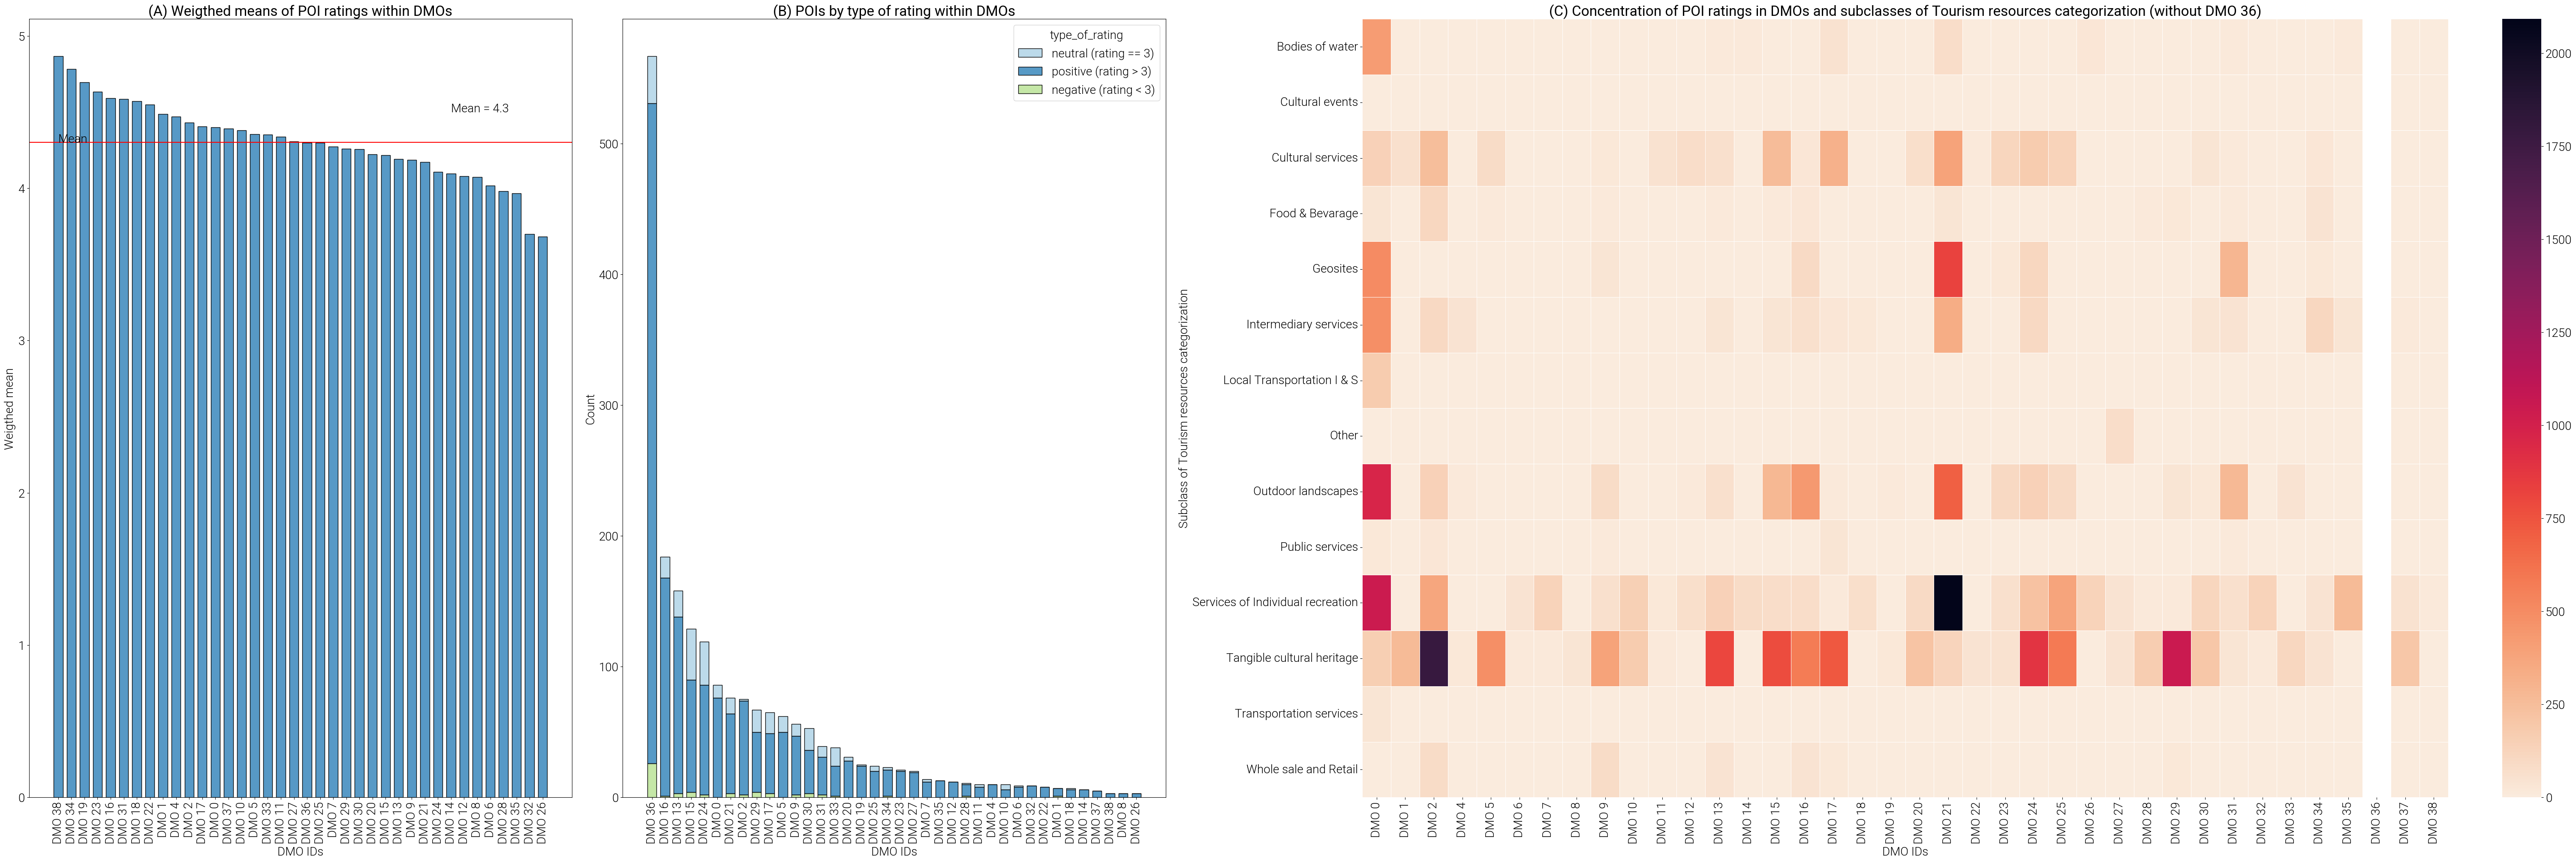

In [5]:
import matplotlib.gridspec as gridspec

#RATINGS
fig3 = plt.figure(constrained_layout=True, figsize=(60, 20))
gs = fig3.add_gridspec(1, 4)
ax1 = fig3.add_subplot(gs[0, 0])
ax2 = fig3.add_subplot(gs[0, 1])
ax3 = fig3.add_subplot(gs[0, 2:])



#ax4 = fig.add_subplot(gs[0, 3])




#################G1 INPUT DATA
dfg1 = pd.pivot_table(df_ta_poi_all.query('nm_dmoid != "NO DMO" and poi_n_reviews.notnull()'), index= ['poi_rating'],  values='poi_n_reviews', aggfunc='sum')
dfg1 = dfg1.reset_index()
dfg1['fj'] = dfg1['poi_n_reviews'] / dfg1['poi_n_reviews'].sum()
dfg1_weighted_mean = sum(dfg1['poi_rating'] * dfg1['fj'])

dfg1_wm_per_dmo_avg_rating = pd.pivot_table(df_ta_poi_all.query('nm_dmoid != "NO DMO" and poi_n_reviews.notnull()'), index= ['nm_dmoid','poi_rating'],  values='poi_n_reviews', aggfunc='sum')
dfg1_wm_per_dmo_avg_rating = dfg1_wm_per_dmo_avg_rating.reset_index()
df_dmo_n_reviews = pd.pivot_table(dfg1_wm_per_dmo_avg_rating, index=['nm_dmoid'], values='poi_n_reviews', aggfunc='sum')
df_dmo_n_reviews = df_dmo_n_reviews.reset_index()

dfg1 = pd.merge(dfg1_wm_per_dmo_avg_rating, df_dmo_n_reviews, on='nm_dmoid', how='outer')
dfg1['fj'] = dfg1['poi_n_reviews_x'] / dfg1['poi_n_reviews_y'] 
dfg1['xjfj'] = dfg1['poi_rating'] * dfg1['fj']
dfg1 = pd.pivot_table(dfg1, index='nm_dmoid', values='xjfj', aggfunc='sum')
dfg1_x_order = list(dfg1.sort_values(by=['xjfj'], ascending=False).index)
dfg1 = dfg1.reset_index()
dfg1['nm_dmoid'] =pd.Categorical(dfg1['nm_dmoid'], dfg1_x_order)

####G1####G1####G1####G1####G1####G1####G1
g1 = sns.histplot(dfg1, x='nm_dmoid', weights='xjfj', ax=ax1, shrink=0.7)
ax1.set_xticklabels(g1.get_xticklabels(), rotation=90)
ax1.set(xlabel="\n".join(textwrap.wrap('DMO IDs',60)), ylabel='Weigthed mean')
ax1.set(title="\n".join(textwrap.wrap("(A) Weigthed means of POI ratings within DMOs",60)))
ax1.axhline(dfg1_weighted_mean, color=clr_mean, label="Weigthed mean")
ax1.annotate("Mean", xy=(0,dfg1_weighted_mean))
ax1.annotate("Mean = " + str(round(dfg1_weighted_mean,1)), xy=(30,4.5))



#####################INPUT DATA FOR G2
df_ta_poi_all['type_of_rating'] = ['negative (rating < 3)' if x < 3 else 'neutral (rating == 3)' if x == 3 else 'positive (rating > 3)' if x > 3 else 0 for x in df_ta_poi_all['poi_rating']]
dfg2 = df_ta_poi_all.groupby(by =['nm_dmoid', 'type_of_rating']).count().reset_index()[['nm_dmoid', 'type_of_rating', 'id']].query('nm_dmoid !="NO DMO" and type_of_rating!=0')
dfg2_x_order = pd.pivot_table(dfg2, index= 'nm_dmoid', values='id', aggfunc='sum').sort_values(by=['id'], ascending=False).index.to_list()
dfg2['nm_dmoid'] = pd.Categorical(dfg2['nm_dmoid'], dfg2_x_order)
####G2####G2####G2####G2####G2####G2####G2####G2####G2
g2 = sns.histplot(data=dfg2, x = "nm_dmoid", multiple="stack", weights ="id", hue="type_of_rating",  palette = sns.color_palette("Paired"), 
                   shrink=0.7, ax=ax2)
ax2.set_xticklabels(g2.get_xticklabels(), rotation=90)
ax2.set(xlabel="\n".join(textwrap.wrap('DMO IDs',60)), ylabel='Count')
ax2.set(title="\n".join(textwrap.wrap("(B) POIs by type of rating within DMOs",60)))


#####################INPUT DATA FOR G3
#dfg3 = pd.pivot_table(df_ta_poi_trp_in_dmo.query('poi_n_reviews.notnull()'), index = ['nm_dmoid', 'trp_2_class'], values='poi_n_reviews', aggfunc='sum').reset_index()
dfg3 = pd.pivot_table(df_ta_poi_trp_in_dmo.query('poi_n_reviews.notnull() and dmo_id != 36'), index = ['trp_3_subclass'], columns=['nm_dmoid'], values='poi_n_reviews', aggfunc='sum')
dfg3 = dfg3.fillna(0)
column_order = ['DMO 0', 'DMO 1', 'DMO 2', 'DMO 4', 'DMO 5', 'DMO 6', 'DMO 7', 'DMO 8', 'DMO 9', 'DMO 10', 'DMO 11', 'DMO 12', 'DMO 13',
'DMO 14', 'DMO 15', 'DMO 16', 'DMO 17', 'DMO 18', 'DMO 19', 'DMO 20', 'DMO 21', 'DMO 22', 'DMO 23', 'DMO 24', 'DMO 25', 'DMO 26',
'DMO 27', 'DMO 28', 'DMO 29', 'DMO 30', 'DMO 31', 'DMO 32', 'DMO 33', 'DMO 34', 'DMO 35', 'DMO 36', 'DMO 37', 'DMO 38']
dfg3 = dfg3.reindex(column_order, axis=1)
#####################G3

#g3 = sns.clustermap(dfg3, linewidths=.5, cmap='coolwarm', figsize=(7,4))
g3 = sns.heatmap(dfg3, linewidths=.5, cmap='rocket_r')
ax3.set(xlabel="\n".join(textwrap.wrap('DMO IDs',60)), ylabel='Subclass of Tourism resources categorization')
ax3.set(title="\n".join(textwrap.wrap("(C) Concentration of POI ratings in DMOs and subclasses of Tourism resources categorization (without DMO 36)",180)))

plt.savefig("dumps/exported_figs/grid_dmo_base_reviews_concentration.svg", bbox_inches="tight")


n_ratings = df_ta_poi_all['poi_n_reviews'].sum()

#df_ta_poi_group_dmo_all
pt_ratings_in_dmo = pd.pivot_table(df_ta_poi_all, index= 'in_dmo', values='poi_n_reviews', aggfunc='sum')
pt_ratings_in_dmo['share'] = pt_ratings_in_dmo['poi_n_reviews'] / pt_ratings_in_dmo['poi_n_reviews'].sum()
pt_ratings_in_dmo



pt_ratings_per_dmo = pd.pivot_table(df_ta_poi_all, index= 'nm_dmoid',  values='poi_n_reviews', aggfunc='sum')
pt_ratings_per_dmo = pt_ratings_per_dmo.query('nm_dmoid != "NO DMO"')
pt_ratings_per_dmo = pt_ratings_per_dmo.sort_values(by=['poi_n_reviews'], ascending = False)
pt_ratings_per_dmo['nm_dmoid'] = pt_ratings_per_dmo.index
pt_ratings_per_dmo['share'] = pt_ratings_per_dmo['poi_n_reviews'] / pt_ratings_per_dmo['poi_n_reviews'].sum()





#

#dxf


df_average_rating_per_dmo = pd.pivot_table(df_ta_poi_all.query('nm_dmoid != "NO DMO" and poi_rating.notnull()'), index='nm_dmoid', values='poi_rating', aggfunc='mean')
df_average_rating_per_dmo_x_order = list(df_average_rating_per_dmo.sort_values(by=['poi_rating'], ascending=False).index)
df_average_rating_per_dmo['nm_dmoid'] = df_average_rating_per_dmo.index
df_average_rating_per_dmo['nm_dmoid'] = pd.Categorical(df_average_rating_per_dmo['nm_dmoid'], df_average_rating_per_dmo_x_order)
df_average_rating_per_dmo['avg_rating'] = round(df_average_rating_per_dmo['poi_rating'],2)













In [7]:
n_ta_pois = len(df_ta_poi.index)
n_ta_pois_review = df_ta_poi['poi_n_reviews'].sum()
n_ta_pois_review_mean = df_ta_poi['poi_rating'].mean()

In [8]:
#TREEMAP TOURISM RESORUCES avg rating
df_ta_poi_trp['n_reviews_total'] = df_ta_poi_trp['n_reviews_total'].fillna(0)
df_ta_poi_trp['avg_rating_per_group'] = df_ta_poi_trp['avg_rating_per_group'].fillna(0)

df_tree = df_ta_poi_trp.query("n_reviews_total !=0")
df_tree = df_ta_poi_trp.reset_index()
df_tree.sort_values(by=['trp_1_source', 'trp_2_class', 'trp_3_subclass'],inplace=True)
#colors_tree = ['#00ced1', '#ffa500', '#00ff00', '#0000ff', '#ff1493']

clrs = ['#750e13', '#a2191f', '#da1e28', '#fa4d56', '#ff8389', '#ffb3b8', '#ffd7d9', '#fff1f1', '#e5f6ff', '#bae6ff', '#82cfff', '#33b1ff', '#1192e8']
dist_clrs = [x for x in clrs[::-1]]

import plotly.express as px
import numpy as np
#df = px.data.gapminder().query("year == 2007")
fig = px.treemap(df_tree.query("n_reviews_total !=0"), path=[px.Constant("TripAdvisor POIs as Tourism Resources"), 'trp_1_source', 'trp_2_class', 'trp_3_subclass'], 
                 values='avg_rating_per_group',color='n_reviews_total',
                  color_continuous_scale=dist_clrs,
                
                  )
n_reviews_total = fig.data[0].marker.colors.tolist()
percents = [round(100*i/sum(df_tree.n_reviews_total),2) for i in n_reviews_total]


## store multiple lists of data in customdata
fig.data[0].customdata = np.column_stack([n_reviews_total, percents])
fig.data[0].texttemplate = "%{label}<br>Mean of Average ratings: %{value}<br>Number (Nr) of ratings: %{customdata[0]}<br>Share on Nr: %{customdata[1]}%"
#fig.update_traces(root_color="lightgrey")

fig.update_layout(width=1500, margin = dict(t=50, l=25, r=25, b=25), font=dict(family="Roboto", size=25))
#paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(0,0,0,0)', 
fig.show()


#import plotly.io as pio
#pio.kaleido.scope.default_format = "svg"
#pio.kaleido.scope.default_scale = 1
#pio.kaleido.scope.default_width = 1500

#fig.to_image(format="svg", engine="kaleido")
fig.write_image("dumps/exported_figs/tremap_ta_poi_n_with_avg_rating.svg")


In [9]:
dfg3_annot =  pd.pivot_table(dfg2, index = 'nm_dmoid', values='id', aggfunc='sum')
dfg3_annot['shar'] =  100*dfg3_annot['id'] / dfg3_annot['id'].sum()
skew(dfg3_annot['id'])


dfg3_dmo36 = pd.pivot_table(df_ta_poi_trp_in_dmo.query('poi_n_reviews.notnull() and dmo_id == 36'), index = ['trp_3_subclass'], columns=['nm_dmoid'], values='poi_n_reviews', aggfunc='sum')
dfg3_dmo36['share'] = 100 * dfg3_dmo36['DMO 36'] / dfg3_dmo36['DMO 36'].sum()
#dfg3_dmo36.sort_values(by=['share'], ascending=False)

df_rev_per_dmo = pd.pivot_table(df_ta_poi_all, index = 'nm_dmoid', values='poi_n_reviews', aggfunc='sum')
df_rev_per_dmo = df_rev_per_dmo.reset_index()

df_rev_vis23_per_dmo = pd.merge(df_rev_per_dmo, df_susr_dist_vis23, on='nm_dmoid', how='outer')
df_rev_vis23_per_dmo.query('poi_n_reviews.notnull() and nm_dmoid != "NO DMO"')

df_rev_vis23_per_dmo['explainable'] = round(100*df_rev_vis23_per_dmo['poi_n_reviews'] / df_rev_vis23_per_dmo['vis_sum_months'], 2)
df_rev_vis23_per_dmo = df_rev_vis23_per_dmo.query('explainable.notnull()')


#df_rev_vis23_per_dmo['explainable'].mean()


#df = px.data.gapminder().query("year == 2007")
fig = px.treemap(df_rev_vis23_per_dmo.sort_values(by=['explainable'], ascending=False), path=[px.Constant('(Theoretical model) Percentage of explainable tourist experiences via POI ratings'),'nm_dmoid'], 
                 values='explainable',color='explainable',
                  color_continuous_scale=dist_clrs,
                 labels = {"explainable": "%"}
                
                  )

fig.data[0].texttemplate = "%{label}<br>Percentage of explainable experiences:<br>%{value}%"
fig.update_layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)', width=1500, margin = dict(t=50, l=25, r=25, b=25), font=dict(family="Roboto", size=30))

fig.show()
fig.write_image("dumps/exported_figs/tremap_explainable_treemap.svg")


In [10]:
#TREEMAP TOURISM RESORUCES N POI with N rating
df_ta_poi_trp['n_reviews_total'] = df_ta_poi_trp['n_reviews_total'].fillna(0)
df_ta_poi_trp['avg_rating_per_group'] = df_ta_poi_trp['avg_rating_per_group'].fillna(0)

df_tree = df_ta_poi_trp.reset_index()
df_tree.sort_values(by=['trp_1_source', 'trp_2_class', 'trp_3_subclass'],inplace=True)


percents = (100*df_ta_poi_trp.n_reviews_total / sum(df_ta_poi_trp.n_reviews_total)).tolist()

#dist_colors = ['#fff7ec', '#fee8c8', '#fdd49e', '#fdbb84', '#fc8d59', '#ef6548', '#d7301f', '#b30000', '#7f0000']
clrs = ['#750e13', '#a2191f', '#da1e28', '#fa4d56', '#ff8389', '#ffb3b8', '#ffd7d9', '#fff1f1', '#e5f6ff', '#bae6ff', '#82cfff', '#33b1ff', '#1192e8']
dist_clrs = [x for x in clrs[::-1]]
import plotly.express as px
import numpy as np
#df = px.data.gapminder().query("year == 2007")
fig = px.treemap(df_tree, path=[px.Constant("TripAdvisor POIs as Tourism Resources"), 'trp_1_source', 'trp_2_class', 'trp_3_subclass'], 
                 values='count',
                 color='n_reviews_total',
                  #color_continuous_scale=px.colors.sequential.Plasma_r,
                 color_continuous_scale = dist_clrs,
                 range_color = [0,60000],
                 #color_discrete_map={'(?)':'#0678D5'}
                 branchvalues = "total",
                 maxdepth = -1
                 
                )

n_reviews_total = fig.data[0].marker.colors.tolist()
percents = [round(100*i/sum(df_tree.n_reviews_total),2) for i in n_reviews_total]


## store multiple lists of data in customdata
fig.data[0].customdata = np.column_stack([n_reviews_total, percents])
fig.data[0].texttemplate = "%{label}<br>(N) Number of POIs: %{value}<br>Share on N: %{percentRoot}<br>Share on parent N: %{percentParent}<br>Number (Nr) of ratings: %{customdata[0]}<br>Share on Nr: %{customdata[1]}%"
#fig.update_traces(root_color="lightgrey")

fig.update_layout(width=1500, margin = dict(t=50, l=25, r=25, b=25), font=dict(family="Roboto", size=25))
#paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(0,0,0,0)', 
fig.show()

#labels=%{label}<br>count=%{value}<br>parent=%{parent}<br>id=%{id}<br>n_reviews_total=%{color}<extra></extra>
fig.write_image("dumps/exported_figs/tremap_ta_poi_n_with_n_rating.svg")
#Finally, the template string has access to variables `currentPath`, `root`, `entry`, `percentRoot`, `percentEntry`, `percentParent`, `label` and `value`.

array(['DMO 31', 'DMO 13', 'DMO 16', 'DMO 2', 'DMO 9', 'DMO 24', 'DMO 21',
       'DMO 5', 'DMO 25', 'DMO 17', 'DMO 15', 'DMO 23', 'DMO 29',
       'DMO 27', 'DMO 32', 'DMO 1', 'DMO 0', 'DMO 19', 'DMO 30', 'DMO 28',
       'DMO 8', 'DMO 20', 'DMO 33', 'DMO 6', 'DMO 12', 'DMO 37', 'DMO 7',
       'DMO 35', 'DMO 4', 'DMO 34', 'DMO 11', 'DMO 22', 'DMO 26',
       'DMO 14', 'DMO 18', 'DMO 38', 'DMO 10'], dtype=object)

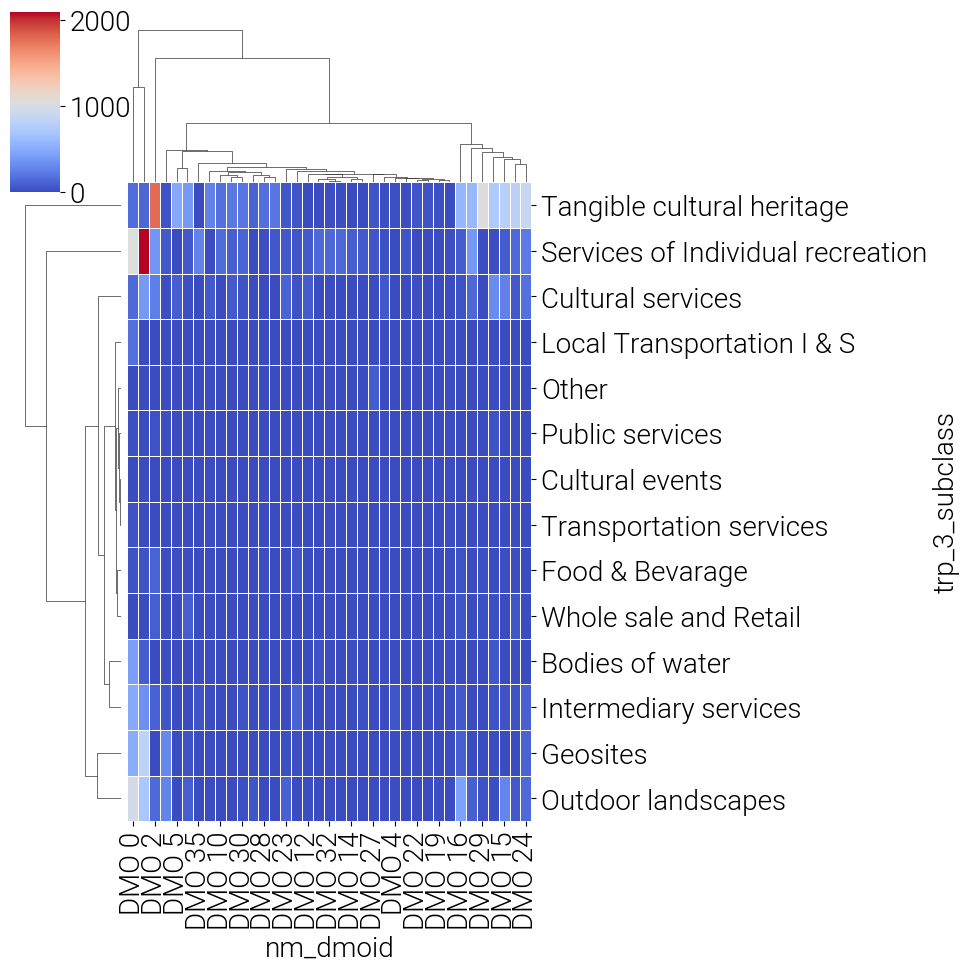

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load the example flights dataset and convert to long-form
flights_long = sns.load_dataset("flights")
flights = (
    flights_long
    .pivot(index="month", columns="year", values="passengers")
)

# Draw a heatmap with the numeric values in each cell
#f, ax = plt.subplots(figsize=(9, 6))
#sns.heatmap(flights, annot=True, fmt="d", linewidths=.5, ax=ax)

dfg3 = pd.pivot_table(df_ta_poi_trp_in_dmo.query('poi_n_reviews.notnull() and dmo_id !=36'), index = ['trp_3_subclass'], columns=['nm_dmoid'], values='poi_n_reviews', aggfunc='sum')
#sns.heatmap(dfg3, annot=True, fmt="d", linewidths=.5)
dfg3 = dfg3.fillna(0)
#sns.heatmap(dfg3, annot=True, fmt="d", linewidths=.5)
sns.clustermap(dfg3, linewidths=.5, cmap='coolwarm')
df_ta_poi_trp_in_dmo.query('poi_n_reviews.notnull() and dmo_id !=36')['nm_dmoid'].unique()

In [3]:
df_geosites_trp = df_trp_all.query('trp_3_subclass == "Geosites"')
n_df_geosites_trp = pd.pivot_table(df_geosites_trp, index=['trp_4_groups', 'trp_5_subgroups' ], values='id', aggfunc='count')
n_df_geosites_trp = n_df_geosites_trp.reset_index()
n_df_geosites_trp

n_reviews_df_geosites_trp = pd.pivot_table(df_geosites_trp, index=['trp_4_groups', 'trp_5_subgroups' ], values='poi_n_reviews', aggfunc='sum')
n_reviews_df_geosites_trp = n_reviews_df_geosites_trp.reset_index()
n_reviews_df_geosites_trp

pd.merge(n_df_geosites_trp, n_reviews_df_geosites_trp, on =['trp_4_groups', 'trp_5_subgroups' ], how ='outer')


df_gsts = df_trp_all.query('trp_3_subclass == "Geosites"')[['trp_4_groups', 'trp_5_subgroups', 'poi_name', 'poi_n_reviews']]
#list(df_gsts.sort_values(by='poi_name', ascending=False)['poi_name'])

df_gsts

trp_4_groups        trp_5_subgroups             poi_name  \
105      Water falls             Waterfalls  Starohutsky vodopad   
165            Caves        Caverns & Caves         Zvonivá Jama   
193          Springs  Hot Springs & Geysers   Thermal Park Vrbov   
197   Other geosites              Mountains       Predné Solisko   
285            Caves        Caverns & Caves    Diviačia Priepasť   
...              ...                    ...                  ...   
2268  Other geosites              Mountains           Baraniarky   
2407           Caves        Caverns & Caves  Demanovska Ice Cave   
2486           Caves        Caverns & Caves       Skalistý Potok   
2534           Caves        Caverns & Caves     Jasovská jaskyňa   
2535         Canyons                Canyons      Monastery Gorge   

      poi_n_reviews  
105             4.0  
165             1.0  
193           108.0  
197            46.0  
285             1.0  
...             ...  
2268            1.0  
2407          252.0  
2486            1.0  
2534            NaN  
2535            8.0  

[69 rows x 4 columns]

In [49]:
with engine.connect() as con1:
    q= """
    with bar as (
    with foo as (
    select * from gtlab.sk_pois_activities_tripadvisor_0723_details
    left join (select * from gtlab.sk_ta_trp_cat_test) trp using (id)
    left join (select id tr_subgroup_5, name trp_5_subgroups  from gtlab.trp_5_subgroups) trp5 using(tr_subgroup_5)
        )
    select * from foo where trp_3_subclass = 'Geosites'
    )
    (select 'Geosites' from_node, 'Geosites' to_node, count(*) n, sum(poi_n_reviews) poi_n_reviews from bar )
    union all
    (select 'Geosites' from_node, trp_4_groups to_node, count(*) n, sum(poi_n_reviews) weight from bar group by trp_4_groups order by to_node)
    union all
    (select trp_4_groups from_node, poi_name, count(*) n, sum(poi_n_reviews) weight from bar group by trp_4_groups, poi_name order by from_node, poi_name)
    """
    df = pd.read_sql(q, con=con1)
    con1.close()
df = df.fillna(1)


for i, from_node in zip(df.index, df['from_node']):
    if len(from_node.split(' ')) > 1:
        wrap_from = max([len(x) for x in from_node.split(' ')])
        df.loc[i, 'from_node'] = "\n".join(textwrap.wrap(from_node, wrap_from))
    
    
for i, to_node in zip(df.index, df['to_node']):
    if len(to_node.split(' ')) > 1:
        wrap_to = max([len(x) for x in to_node.split(' ')])
        df.loc[i, 'to_node'] = "\n".join(textwrap.wrap(to_node, wrap_to))
        


In [50]:
df_copy = df.copy()
clr_df_1 = pd.pivot_table(df_copy.query('from_node == "Geosites" and to_node != "Geosites"'), index = ['to_node'], values='poi_n_reviews', aggfunc='sum')
clr_df_1 = clr_df_1.reset_index()
clr_df_1['clr_df1_share'] = clr_df_1['poi_n_reviews'] /clr_df_1['poi_n_reviews'].sum()
clr_df_1

clr_df_2 = pd.pivot_table(df_copy.query('from_node != "Geosites"'), index = ['from_node','to_node'], values='poi_n_reviews', aggfunc='sum')
clr_df_2 = clr_df_2.reset_index()
clr_df_2['clr_df1_share'] = clr_df_2['poi_n_reviews'] /clr_df_2['poi_n_reviews'].sum()

clr_df_2 = pd.merge(clr_df_1, clr_df_2, left_on = 'to_node', right_on='from_node', how='outer')
clr_df_2['child_share'] = clr_df_2['poi_n_reviews_y'] / clr_df_2['poi_n_reviews_x']
clr_df_2
clr_df_1


l_share = []
l_share.append(1.0)
l_shares = l_share + list(clr_df_1['clr_df1_share']) + list(clr_df_2['child_share'])
#len(sizes_x)
len(l_shares)

ndx_colors = ['#e1e8fb', '#bfcbee', '#9eb0e5', '#3e5fcc']
clr_list_ndx = []
for x in l_shares:
    if x < 0.25:
        #under 25 %
        x_color = ndx_colors[0]
        #greater thant 25% lower than 50%
        clr_list_ndx.append(x_color)
    elif x >= 0.25 and x < 0.5:
        x_color = ndx_colors[1]
        clr_list_ndx.append(x_color)
        #greater than 50% lower than 75%
    elif x >= 0.5 and x < 0.75:
        x_color = ndx_colors[2]
        clr_list_ndx.append(x_color)
        #greater than 50% or equal to 100%
    elif x >= 0.75 and x <= 1:
        x_color = ndx_colors[3]
        clr_list_ndx.append(x_color)
    


In [63]:
df

from_node                      to_node   n  poi_n_reviews
0       Geosites                     Geosites  69         2119.0
1       Geosites                      Canyons   5          126.0
2       Geosites                        Caves  27         1405.0
3       Geosites              Other\ngeosites  22          304.0
4       Geosites                      Springs   3          114.0
..           ...                          ...  ..            ...
68  Water\nfalls          Poľovníkov\nVodopád   1            1.0
69  Water\nfalls         Starohutsky\nvodopad   1            4.0
70  Water\nfalls          Turova's\nWaterfall   1            1.0
71  Water\nfalls  Vodopády\nStudeného\nPotoka   1            1.0
72  Water\nfalls              Waterfall\nSkok   1           46.0

[73 rows x 4 columns]

In [67]:
list(df['n'])
edges_weights = []
for n in list(df['n']):
    if n == 1:
        edge_wdth = 0.1
        edges_weights.append(edge_wdth)
    elif n!=1:
        edge_wdth = n/10
        edges_weights.append(edge_wdth)
        


[6.9,
 0.5,
 2.7,
 2.2,
 0.3,
 1.2,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.2,
 0.1,
 0.1,
 0.1,
 0.2,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1]

In [68]:
#get all sizes including root's
sizes_x = [x for x in df['poi_n_reviews']] 
#exclude edge root -> root
df_nodes = df.query('from_node != to_node')
#obsolete but keep while testing rendering

sizes_x = [x*15 for x in sizes_x]
weigths = [0.25 for x in sizes_x]



import pandas as pd
import networkx as nx

#fig = matplotlib.pyplot.figure(figsize=(20, 20))

G = nx.Graph() # Create an empty undirected graph (or nx.DiGraph() for a directed graph)
# Add nodes from the 'source' and 'target' columns
G.add_nodes_from(df_nodes['from_node'])
G.add_nodes_from(df_nodes['to_node'])



# Add edges from the DataFrame
edges = [(row['from_node'], row['to_node']) for index, row in df.iterrows()]
G.add_edges_from(edges)
#nx.draw_shell(G)

#import matplotlib.pyplot as plt
# Draw the graph
pos = nx.kamada_kawai_layout(G) # Define the layout for node positioning
fig = plt.figure(figsize=(25,12)) 
nx.draw(G, pos, with_labels=True, node_size=sizes_x, node_color=clr_list_ndx, font_size=15, font_color='black', font_family='Roboto', font_weight='light', width=edges_weights)
#matplotlib.pyplot.show()
# Display the graph
#if True: 
    # Save plot to file
#    matplotlib.use("Agg") 
#    fig.savefig("dumps/exported_figs/kamada_kawai_geosites.svg", bbox_inches="tight")
#else:
    # Display interactive viewer
#    matplotlib.pyplot.show()

#plt.show()

#edge width
#node color scale
#f



C:\Users\csb\AppData\Local\Temp\ipykernel_9372\3006358943.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  matplotlib.pyplot.show()


In [9]:
df_geo_dmo_rev

nm_dmoid  poi_n_reviews
0     DMO 0          500.0
1    DMO 12            1.0
2    DMO 15            1.0
3    DMO 16           90.0
4    DMO 21          823.0
5    DMO 23           21.0
6    DMO 24          113.0
7    DMO 29            1.0
8    DMO 31          286.0
9    DMO 34           17.0
10    DMO 6            4.0
11    DMO 9           38.0
12   NO DMO          224.0

C:\Users\csb\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\csb\AppData\Local\Temp\ipykernel_748\406628096.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(g1.get_xticklabels(), rotation=90)
C:\Users\csb\AppData\Local\Temp\ipykernel_748\406628096.py:41: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\csb\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\csb\AppData\Local\Temp\ipykernel_748\406628096.py:44: UserWarning: 

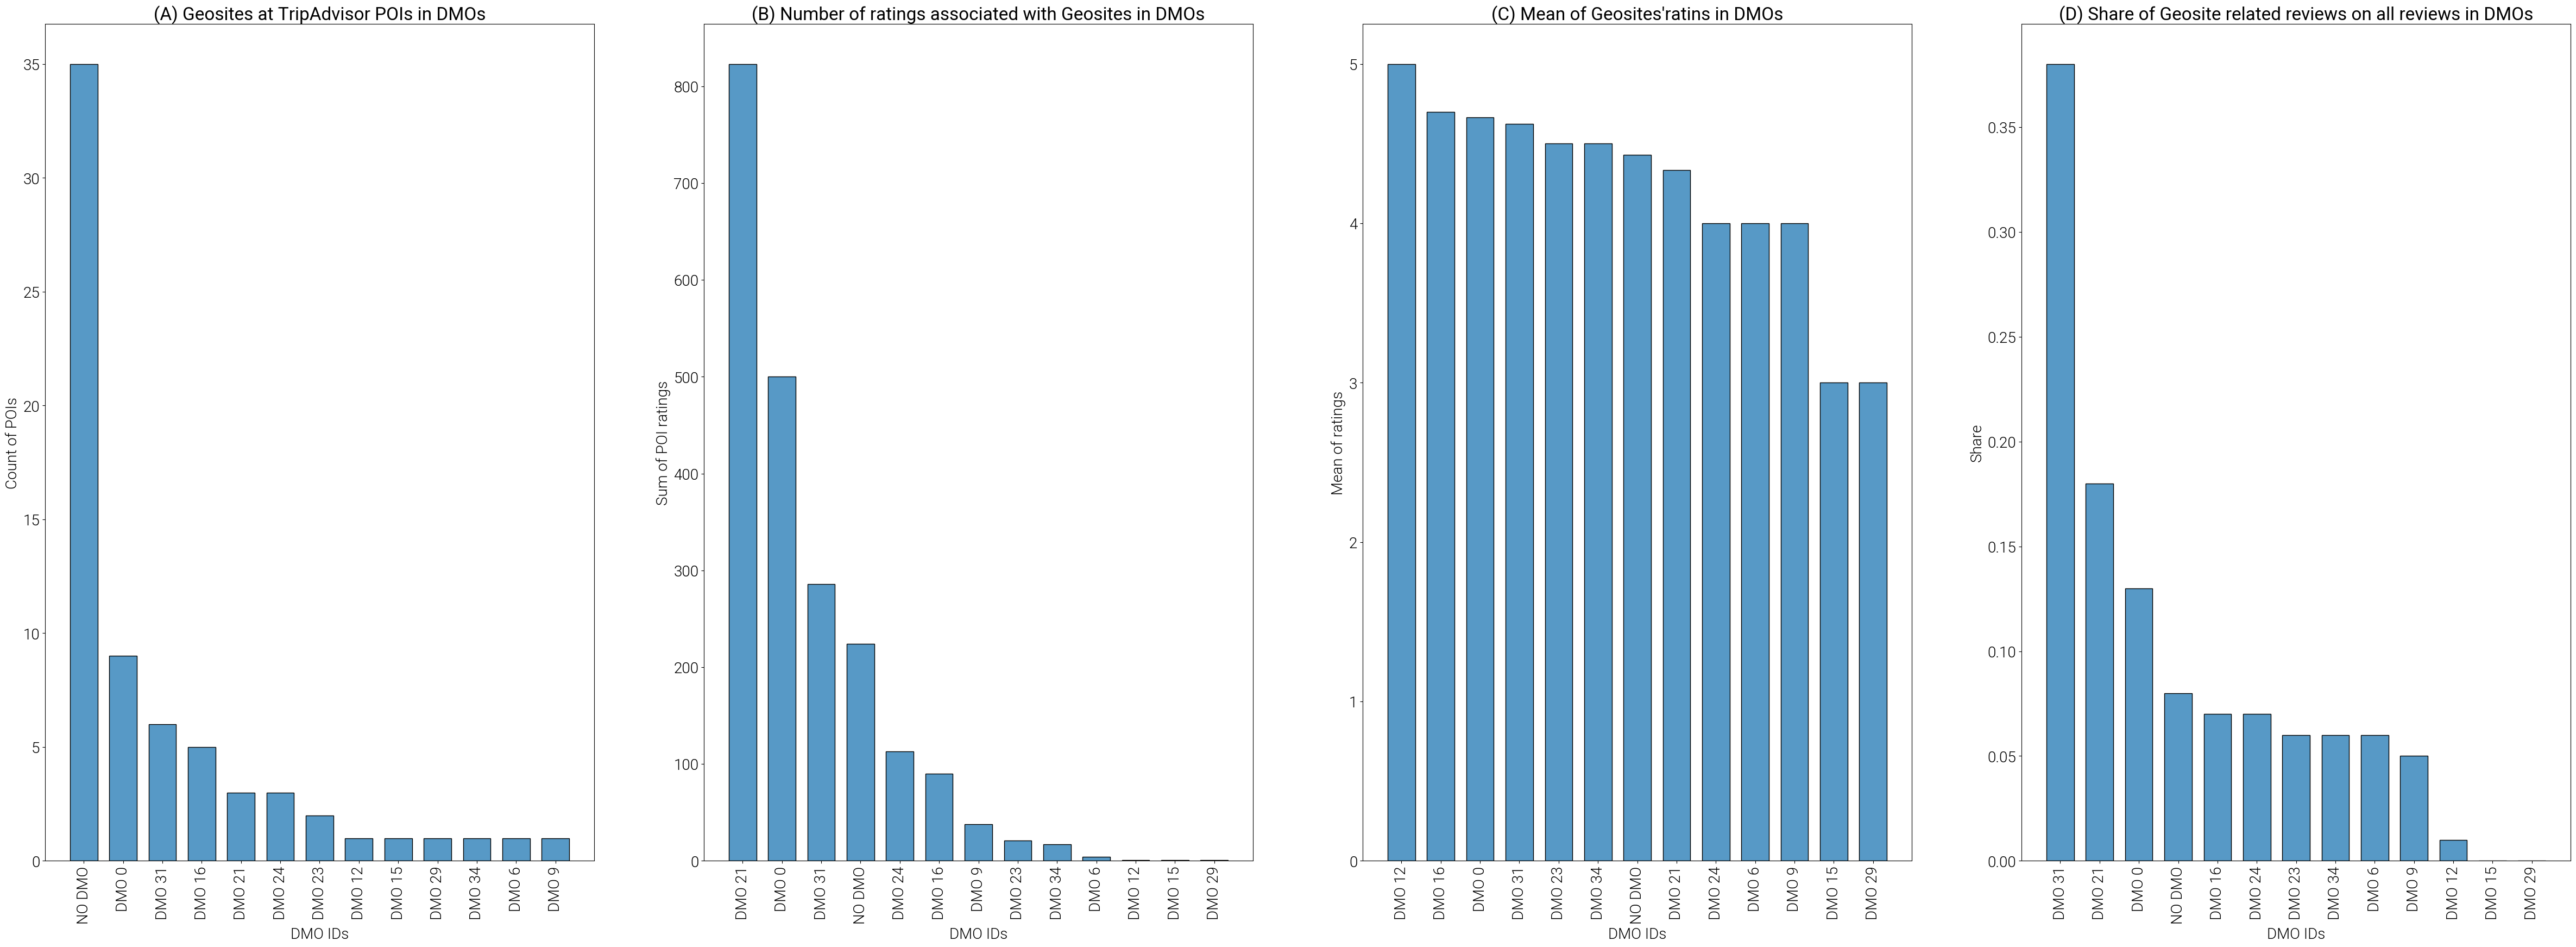

In [41]:
df_geo_dmo = pd.pivot_table(df_trp_all.query('trp_3_subclass == "Geosites"'), index = ['nm_dmoid'], values='id', aggfunc='count')
df_geo_dmo = df_geo_dmo.reset_index()

list(df_geo_dmo.sort_values(by=['id'], ascending=False)['nm_dmoid'])
df_geo_dmo['nm_dmoid'] = pd.Categorical(df_geo_dmo['nm_dmoid'], list(df_geo_dmo.sort_values(by=['id'], ascending=False)['nm_dmoid']))

df_geo_dmo_rev = pd.pivot_table(df_trp_all.query('trp_3_subclass == "Geosites"'), index = ['nm_dmoid'], values='poi_n_reviews', aggfunc='sum')
df_geo_dmo_rev = df_geo_dmo_rev.reset_index()
df_geo_dmo_rev = df_geo_dmo_rev.fillna(0)
df_geo_dmo_rev['nm_dmoid'] = pd.Categorical(df_geo_dmo_rev['nm_dmoid'], list(df_geo_dmo_rev.sort_values(by=['poi_n_reviews'], ascending=False)['nm_dmoid']))


df_geo_dmo_avg_rev = pd.pivot_table(df_trp_all.query('trp_3_subclass == "Geosites"'), index = ['nm_dmoid'], values='poi_rating', aggfunc='mean')
df_geo_dmo_avg_rev = df_geo_dmo_avg_rev.reset_index()
df_geo_dmo_avg_rev['nm_dmoid'] = pd.Categorical(df_geo_dmo_avg_rev['nm_dmoid'], list(df_geo_dmo_avg_rev.sort_values(by=['poi_rating'], ascending=False)['nm_dmoid']))


df_geo_merged = pd.merge(df_geo_dmo, df_geo_dmo_rev, on ='nm_dmoid', how='outer')
df_geo_merged = pd.merge(df_geo_merged, df_geo_dmo_avg_rev, on ='nm_dmoid', how='outer')

df_dmo = pd.pivot_table(df_trp_all, index='nm_dmoid', values='poi_n_reviews', aggfunc='sum')
df_dmo = df_dmo.reset_index()
df_geo_merged = pd.merge(df_geo_merged, df_dmo, on='nm_dmoid', how='left' )
df_geo_merged['geo_share'] =  round(df_geo_merged['poi_n_reviews_x'] / df_geo_merged['poi_n_reviews_y'] ,2) 
df_geo_merged['nm_dmoid'] = pd.Categorical(df_geo_merged['nm_dmoid'], list(df_geo_merged.sort_values(by=['geo_share'], ascending=False)['nm_dmoid']))


fig = plt.figure(figsize=(60, 20))
gs = GridSpec(1, 4, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[0, 3])


g1 = sns.histplot(data=df_geo_dmo, x = "nm_dmoid", weights='id', kde=False,shrink = 0.7, ax=ax1)
ax1.set_xticklabels(g1.get_xticklabels(), rotation=90)
ax1.set(xlabel="\n".join(textwrap.wrap('DMO IDs',60)), ylabel='Count of POIs')
ax1.set(title="\n".join(textwrap.wrap("(A) Geosites at TripAdvisor POIs in DMOs",60)))
fig.show()

g2 = sns.histplot(df_geo_dmo_rev, x = "nm_dmoid", weights='poi_n_reviews', kde=False,shrink = 0.7, ax=ax2)
ax2.set_xticklabels(g2.get_xticklabels(), rotation=90)
ax2.set(xlabel="\n".join(textwrap.wrap('DMO IDs',60)), ylabel='Sum of POI ratings')
ax2.set(title="\n".join(textwrap.wrap("(B) Number of ratings associated with Geosites in DMOs",60)))
fig.show()

g3 = sns.histplot(df_geo_dmo_avg_rev, x = "nm_dmoid", weights='poi_rating', kde=False,shrink = 0.7, ax=ax3)
ax3.set_xticklabels(g3.get_xticklabels(), rotation=90)
ax3.set(xlabel="\n".join(textwrap.wrap('DMO IDs',60)), ylabel='Mean of ratings')
ax3.set(title="\n".join(textwrap.wrap("(C) Mean of Geosites'ratins in DMOs",60)))
fig.show()

g4 = sns.histplot(df_geo_merged, x = "nm_dmoid", weights='geo_share', kde=False,shrink = 0.7, ax=ax4)
ax4.set_xticklabels(g4.get_xticklabels(), rotation=90)
ax4.set(xlabel="\n".join(textwrap.wrap('DMO IDs',60)), ylabel='Share')
ax4.set(title="\n".join(textwrap.wrap("(D) Share of Geosite related reviews on all reviews in DMOs",60)))
fig.show()

plt.savefig("dumps/exported_figs/grid_ta_geosites_dmo.svg", bbox_inches="tight")


In [42]:
df_geo_merged

nm_dmoid  id  poi_n_reviews_x  poi_rating  poi_n_reviews_y  geo_share
0     DMO 0   9            500.0    4.666667           3994.0       0.13
1    DMO 12   1              1.0    5.000000            161.0       0.01
2    DMO 15   1              1.0    3.000000           1453.0       0.00
3    DMO 16   5             90.0    4.700000           1351.0       0.07
4    DMO 21   3            823.0    4.333333           4583.0       0.18
5    DMO 23   2             21.0    4.500000            363.0       0.06
6    DMO 24   3            113.0    4.000000           1647.0       0.07
7    DMO 29   1              1.0    3.000000           1148.0       0.00
8    DMO 31   6            286.0    4.625000            760.0       0.38
9    DMO 34   1             17.0    4.500000            291.0       0.06
10    DMO 6   1              4.0    4.000000             63.0       0.06
11    DMO 9   1             38.0    4.000000            706.0       0.05
12   NO DMO  35            224.0    4.431034           2812.0       0.08